In [1]:
!pip install matplotlib


In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.middle = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


In [3]:
def load_generator(model_path, device):
    model = UNetGenerator().to(device)
    state_dict = torch.load(model_path, map_location=device)
    
    # Support both full checkpoint and just the generator weights
    if "generator" in state_dict:
        model.load_state_dict(state_dict["generator"])
    else:
        model.load_state_dict(state_dict)
    
    model.eval()
    return model

In [4]:
# 3. Preprocess Input Image
# ======================
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    original_size = image.size
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    tensor = transform(image).unsqueeze(0)
    return tensor, image, original_size
    

In [5]:
# 4. Postprocess Output Tensor
# ======================
def postprocess_tensor(tensor):
    tensor = tensor.squeeze(0).detach().cpu()
    tensor = (tensor * 0.5 + 0.5).clamp(0, 1)  # De-normalize
    return transforms.ToPILImage()(tensor)


In [6]:
def cartoonize_image(model_path, input_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_generator(model_path, device)

    input_tensor, original_image, original_size = preprocess_image(input_path)
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        output_tensor = model(input_tensor)

    cartoon_image = postprocess_tensor(output_tensor)
    cartoon_image = cartoon_image.resize(original_size, Image.LANCZOS)

    return cartoon_image


/tmp/ipykernel_22646/2930883342.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


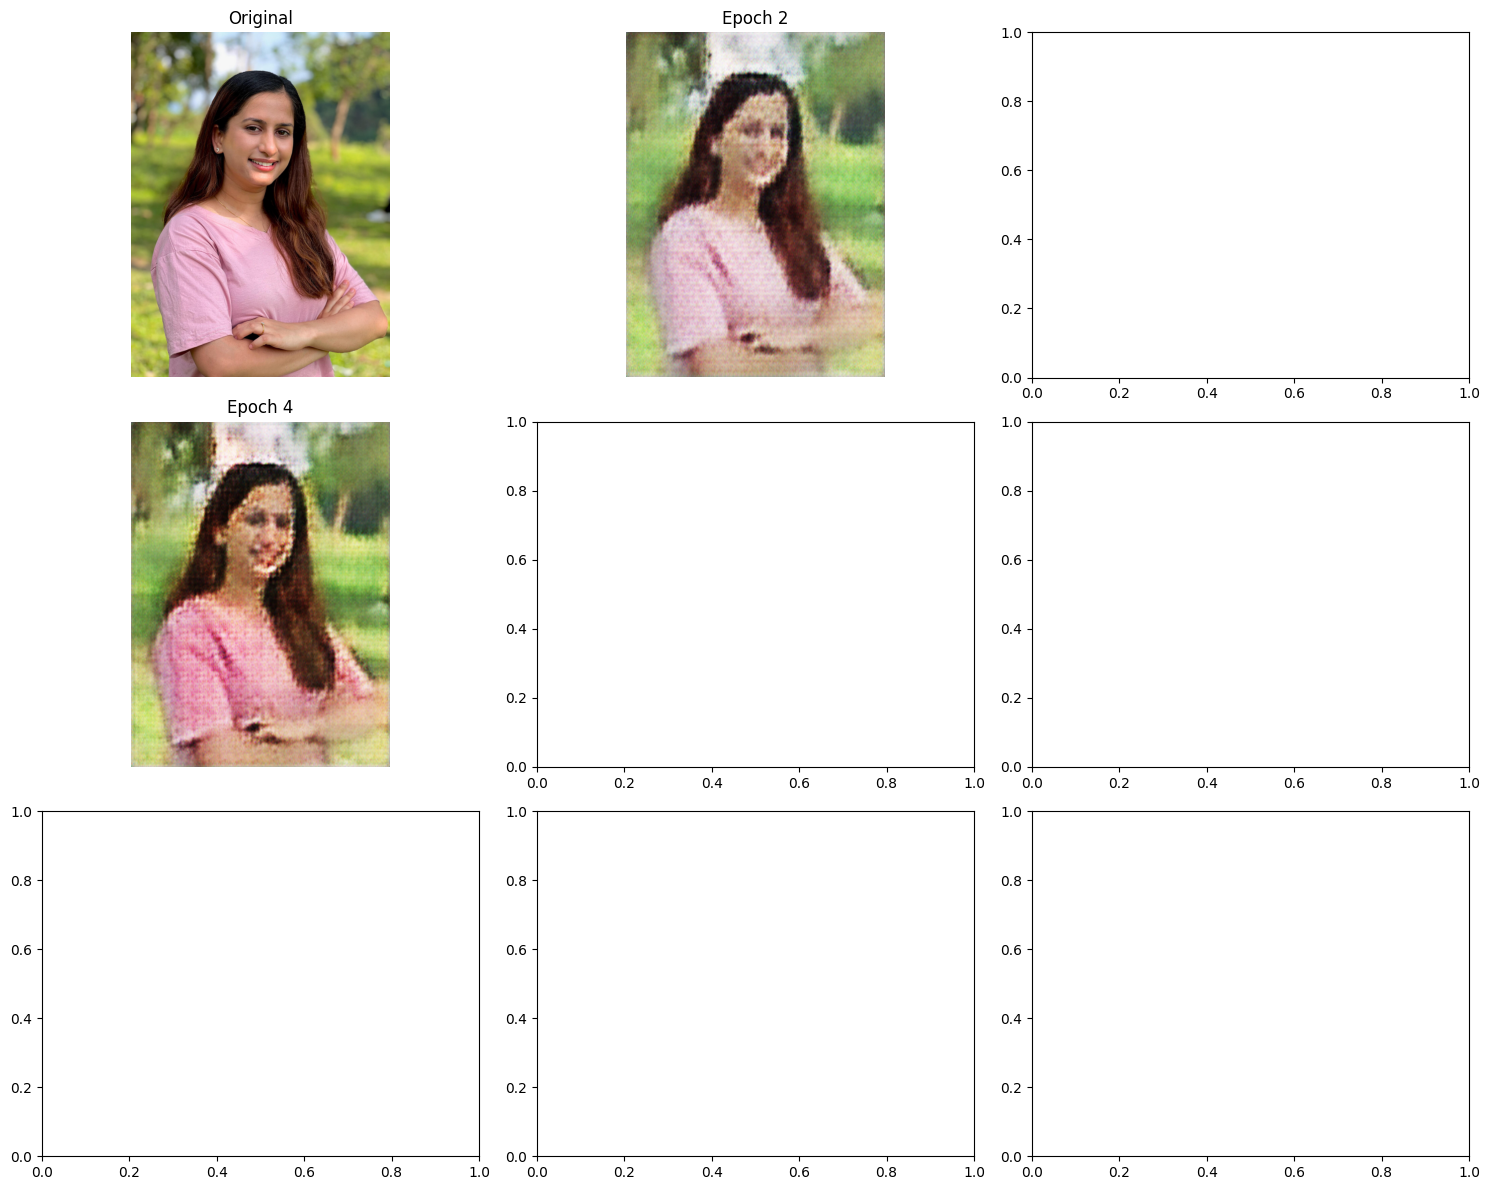

In [13]:
import matplotlib.pyplot as plt
from PIL import Image

input_image_path = "../data/input/sujata_adhikari.jpg"

# Checkpoints and corresponding labels
checkpoints = {
    "Original": None,
    "Epoch 2": "cartoongan_epoch2.pth",
    "Epoch 4": "cartoongan_epoch4.pth",
    # "Epoch 60": "cartoongan_epoch60.pth",
    # "Epoch 80": "cartoongan_epoch80.pth",
    # "Epoch 100": "cartoongan_epoch100.pth",
    # "Epoch 120": "cartoongan_epoch120.pth",
    # "Epoch 140": "cartoongan_epoch140.pth",
    # "Epoch 150": "cartoongan_epoch150.pth",
    
}

# Run cartoonization for each checkpoint
results = {}
for label, ckpt in checkpoints.items():
    if ckpt is None:
        results[label] = Image.open(input_image_path)
    else:
        ckpt_path = f"../experiments/exp2/checkpoints/{ckpt}" 
        cartoon_img = cartoonize_image(ckpt_path, input_image_path)
        results[label] = cartoon_img

# Plotting in 2 rows and 4 columns
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i, (label, image) in enumerate(results.items()):
    ax = axes[i // 2][i % 2]
    ax.imshow(image)
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [12]:
import matplotlib.pyplot as plt
from PIL import Image

input_image_path = "../data/input/sujata_adhikari.jpg"

# Checkpoints and corresponding labels
checkpoints = {
    "Original": None,
    "Epoch 20": "cartoongan_epoch20.pth",
    "Epoch 40": "cartoongan_epoch40.pth",
    "Epoch 60": "cartoongan_epoch60.pth",
    "Epoch 80": "cartoongan_epoch80.pth",
    "Epoch 100": "cartoongan_epoch100.pth",
    "Epoch 120": "cartoongan_epoch120.pth",
    "Epoch 140": "cartoongan_epoch140.pth",
    "Epoch 150": "cartoongan_epoch150.pth",
    
}

# Run cartoonization for each checkpoint
results = {}
for label, ckpt in checkpoints.items():
    if ckpt is None:
        results[label] = Image.open(input_image_path)
    else:
        ckpt_path = f"../checkpoints/exp1/{ckpt}" 
        cartoon_img = cartoonize_image(ckpt, input_image_path)
        results[label] = cartoon_img

# Plotting in 2 rows and 4 columns
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
for i, (label, image) in enumerate(results.items()):
    ax = axes[i // 3][i % 3]
    ax.imshow(image)
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()


/tmp/ipykernel_22646/2930883342.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


FileNotFoundError: [Errno 2] No such file or directory: 'cartoongan_epoch20.pth'

In [16]:
# Replace with your actual paths
model_path120 = "cartoongan_epoch120.pth"
model_path130 = "cartoongan_epoch140.pth"
model_path80 = "cartoongan_epoch80.pth"

model_path10 = "cartoongan_epoch10.pth"

input_image_path = "../sujata_adhikari.jpg"
output_image_path = "my_photo_cartoon.jpg"

cartoon_image = cartoonize_image(model_path150, input_image_path, output_image_path)

cartoon_image2 = cartoonize_image(model_path80, input_image_path, output_image_path)
cartoon_image2 = cartoonize_image(model_path120, input_image_path, output_image_path)
cartoon_image2 = cartoonize_image(model_path130, input_image_path, output_image_path)



NameError: name 'model_path150' is not defined